## Cleaning and Exploratory Data Analysis 

In this notebook, we will perform the cleaning and exploration of the data.


In [1]:
%matplotlib inline
from IPython.display import display

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from mtcars_practice.config import data_dir

In [2]:
mtcars = pd.read_csv(data_dir + '/processed/mtcars.csv')
display(mtcars.head())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Taking a look at the first few rows of the dataset, we can see the distribution of mpg, the dependent variable. The variables cylinders, displacement, horsepower, weight, acceleration seem like good candidates to be independent variables. We can take a look at the model_year variable to see if it would be helpful to include. The documentation does not describe exactly what the variable origin is denoting, yet I would guess it is the country or region where the vehicle was built. If this is the case, then including it would be potentially beneficial. The car_name attribute will be dropped, as it is of no use.

Of note is that upon running the code the first time, horsepower was not being displayed in the describe output. The reason for this is that it was being stored as dtype object (string), so casting it to float was attempted, but there were 6 values of "?". We change these to NA values, and then cast to float.

In [3]:
mtcars['horsepower'] = mtcars['horsepower'].replace('?', np.nan).astype('float64')
mtcars.drop('car_name', axis=1, inplace=True)

display(mtcars.describe())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


The description of the dataset above shows us the distribution of the independent variables. Notably, we can see that model_year ranges from 70 to 82, which makes this variable more of a categorical variable. The origin variable is clearly categorical with 3 categories.

The following table examines the data for any missingness. The only variable with missing values is horsepower, of which there are six cases. Since it is a rather small number, imputing it with the median should not bias the data very much. We will wait to do that when cleaning the data in a later step. 

In [4]:
missing = mtcars.isnull().sum(axis=0)
display(missing.to_frame().rename(columns={0:'missingness'}))

,missingness
mpg,0
cylinders,0
displacement,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0


Firstly, I would like to take a look at the distribution of the categorical variables, so we take a look at the cylinders, model_year, and origin variables. The following are frequency tables for these variables.

In [5]:
display(mtcars['cylinders'].value_counts().sort_index().to_frame())
display(mtcars['model_year'].value_counts().sort_index().to_frame())
display(mtcars['origin'].value_counts().sort_index().to_frame())

,cylinders
3,4
4,204
5,3
6,84
8,103


,model_year
70,29
71,28
72,28
73,40
74,27
75,30
76,34
77,28
78,36
79,29


,origin
1,249
2,70
3,79


The cylinder variables looks to only have 5 categories, two of which have very low counts. There are not many cars that have 3 or 5 cylinders. Upon research, it seems creating cars with 3 and 5 cylinder engines is limited to when companies are feeling experimental. But at least we can confirm that it is not a typo. We can keep these two small-count categories. Since there are only five categories, one-hot encoding should not be an issue.

Due to the limited range of years contained in the model_year variable, I am rather skeptical as to its use for analysis. Treating it as a continuous variable would be inappropriate. Yet treating it as a categorical variable would create some challenges, as using each year as a single category would create many categories, which would then need to be one-hot encoded. This might cause issues in training any models. Creating groupings of years would also be difficult, since any new data would have to be grouped as well, and it is uncertain the range of years that could be encountered in the new data.
But I believe the year a car was made would have a lot of predictive power in relation to its mpg, as this has increased over the years. For this reason, I would like to keep it, if only just to test its usefulness. The only way to include it would be as an ordinal variable in my view. But many machine learning models require the data to be scaled, which is an odd operation to perform on an ordinal variable. Therefore, I think removing it from the data is best.

The distribution of the origin variable seems pretty skewed toward the "1" category, which makes me believe that it represents the "American" category, and the other two categories must represent "European" and "Asian" cars. We could confirm this by looking at the names, but it really should be necessary. Since there are only three categories, this variable would be good to one-hot encode, and I think it would contribute to the predictive power of the model, since differences in the manufacturing process have resulted in differences in mpg between cars manufactured in different locations.

Next we take a look at the continuous predictor variables. Below are shown the summary statistics of the distribution of each variable, as well as a scatterplot matrix showing each variable plotted against each other and a histogram along the diagonal.

In [6]:
display(mtcars[['displacement', 'horsepower', 'weight', 'acceleration']].describe())

,displacement,horsepower,weight,acceleration
count,398.000000,392.000000,398.000000,398.000000
mean,193.425879,104.469388,2970.424623,15.568090
std,104.269838,38.491160,846.841774,2.757689
min,68.000000,46.000000,1613.000000,8.000000
25%,104.250000,75.000000,2223.750000,13.825000
50%,148.500000,93.500000,2803.500000,15.500000
75%,262.000000,126.000000,3608.000000,17.175000
max,455.000000,230.000000,5140.000000,24.800000


array([[<AxesSubplot: xlabel='displacement', ylabel='displacement'>,
        <AxesSubplot: xlabel='horsepower', ylabel='displacement'>,
        <AxesSubplot: xlabel='weight', ylabel='displacement'>,
        <AxesSubplot: xlabel='acceleration', ylabel='displacement'>],
       [<AxesSubplot: xlabel='displacement', ylabel='horsepower'>,
        <AxesSubplot: xlabel='horsepower', ylabel='horsepower'>,
        <AxesSubplot: xlabel='weight', ylabel='horsepower'>,
        <AxesSubplot: xlabel='acceleration', ylabel='horsepower'>],
       [<AxesSubplot: xlabel='displacement', ylabel='weight'>,
        <AxesSubplot: xlabel='horsepower', ylabel='weight'>,
        <AxesSubplot: xlabel='weight', ylabel='weight'>,
        <AxesSubplot: xlabel='acceleration', ylabel='weight'>],
       [<AxesSubplot: xlabel='displacement', ylabel='acceleration'>,
        <AxesSubplot: xlabel='horsepower', ylabel='acceleration'>,
        <AxesSubplot: xlabel='weight', ylabel='acceleration'>,
        <AxesSubplot: xlab

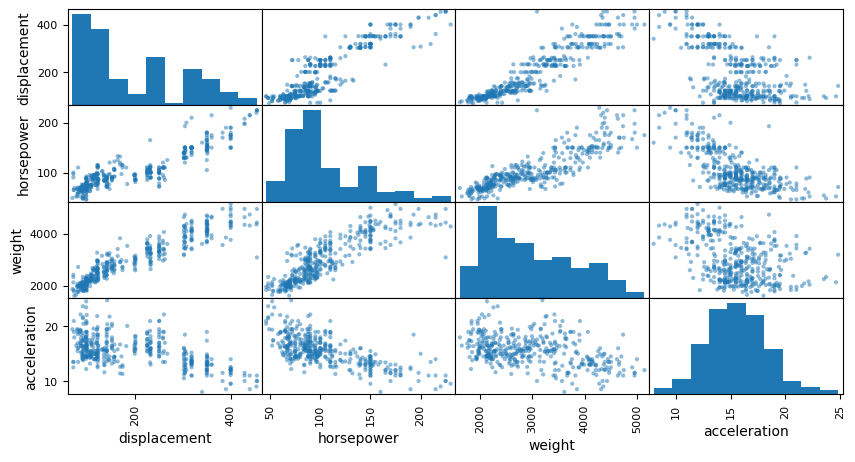

In [7]:
scatter_matrix(mtcars[['displacement', 'horsepower', 'weight', 'acceleration']], figsize=(10, 5))

We can see some notable patterns in these graphs. Some clustering is apparent for the displacement variable, with many values in the range below 150, then a break at around 250, then a small cluster above 300. The distribution of weight looks fairly balanced, although it is slightly right tailed, which I do not think will cause any problems. The distribtution of acceleration looks fairly symmetric. One pattern that may affect some models is that there appears to be a positive linear trend between displacement and weight. According to Wikipedia, "Engine displacement is the measure of the cylinder volume swept by all of the pistons of a piston engine, excluding the combustion chambers. It is commonly used as an expression of an engine's size..". This association would make sense, since larger engines would tend to be in larger cars, which would tend to weigh more. The relationship between acceleration and weight looks to be pretty loose and random. Displacement and acceleration look slightly negatively related, although it definitely does not look like a linear relationship.

Horsepower will have to be imputed later, but for now, it looks fairly right tailed. It seems to have rather linear relationships with all the other continuous variables, both positively and negatively correlated.

At this point, we will split the data into a train and test dataset for model building. We will keep it as a pandas DataFrame since some more preprocessing in needed for some of the variables. For the numeric variables, we scale them using the min-max normalization method. For cylinders and origin, we apply one-hot encoding. For the model_year variable, we transform it into an ordinal variable.

In [8]:
num_cols = ['displacement', 'horsepower', 'weight', 'acceleration']
cat_hot_cols = ['cylinders', 'origin']

mtcars_train, mtcars_test = train_test_split(mtcars, test_size=0.15, random_state=42)

X_train_pre = mtcars_train[num_cols + cat_hot_cols]
X_test_pre = mtcars_test[num_cols + cat_hot_cols]

y_train = mtcars_train['mpg'].to_numpy()
y_test = mtcars_test['mpg'].to_numpy()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat_hot', OneHotEncoder(), cat_hot_cols),
])

X_train = full_pipeline.fit_transform(X_train_pre)
X_test = full_pipeline.transform(X_test_pre)

We save the mtcars train and test DataFrames to the data/processed directory to keep for reference.

In [9]:
mtcars_train.to_csv(data_dir + '/processed/mtcars_train.csv')
mtcars_test.to_csv(data_dir + '/processed/mtcars_test.csv')

Next, we save the X, y train and test Numpy arrays to the data/train_test directory for later use in modeling.

In [10]:
np.save(data_dir + '/train_test/X_train.npy', X_train)
np.save(data_dir + '/train_test/X_test.npy', X_test)

np.save(data_dir + '/train_test/y_train.npy', y_train)
np.save(data_dir + '/train_test/y_test.npy', y_test)